In [1]:
# Necessary libraries
#Libraries used in this notebook , they will be repeated for clairty in the notebook aswell
import pandas as pd
import ast
import requests
from bs4 import BeautifulSoup
import numpy as np
import operator
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score
import time

import matplotlib.pyplot as plt
import seaborn as sns
#Hide Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
df_Soccer = pd.read_csv('df_soccer.csv')

In [3]:
df_Soccer 

,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country,age
0,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017-01-01,Meniscal Injury,29,England,24
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,Achilles tendon rupture,314,England,36
2,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,Disrupted Calf Muscle,57,England,34
3,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Calf Injury,17,England,33
4,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Torn muscle bundle,24,England,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12220,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2016-01-01,Infection,7,Spain,22
12221,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2015-01-01,Unknown Injury,12,Spain,21
12222,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2019-01-01,Flu,7,Spain,20
12223,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2018-01-01,Metatarsal Fracture,47,Spain,19


In [4]:
player_names = df_Soccer['name']
player_names

0                Ederson
1          Claudio Bravo
2          Claudio Bravo
3          Claudio Bravo
4          Claudio Bravo
              ...       
12220        Juanpi Añor
12221        Juanpi Añor
12222    Cucho Hernández
12223    Cucho Hernández
12224    Cucho Hernández
Name: name, Length: 12225, dtype: object

In [5]:
def simplify_role(role):
    role_lower = role.lower()

    if 'defender' in role_lower or 'left-back / wing-back' in role_lower:
        return 'Defender'
    elif 'midfielder' in role_lower:
        return 'Midfielder'
    elif 'forward' in role_lower:
        return 'Forward'
    else:
        return role  # keep the original value if no match

# Apply the function to the 'role' column in your DataFrame
df_Soccer['role'] = df_Soccer['role'].apply(simplify_role)


In [6]:
unique_roles = df_Soccer['role'].unique()
print(unique_roles)


['Goalkeeper' 'Defender' 'Midfielder' 'Forward']


# FM2017_kaagle
Dataset for Football manager 2017 available on Kaagle. We will combine this with the scraped injury data to form a compplete database


In [7]:
# File path
file_path = 'C:\\Users\\Dell\\OneDrive\\Desktop\\Final-player.txt'

# Open the file for reading with UTF-8 encoding
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()

# Evaluate the content to convert it to a Python object
data = ast.literal_eval(content)

# Extract the data into a format suitable for DataFrame
# Initialize an empty list to hold the parsed data
parsed_data = []

# Iterate through each row in the data
for row in data:
    # Unpack the row into individual variables
    player_id, name, club, club_value, birth, weight, height, country, role, foot, transfers, injuries = row
    
    # Convert the list of transfers into a string format
    transfers_str = ', '.join([f'{x[0]} -> {x[1]}, {x[2]}, {x[3]}' for x in transfers])
    
    # Convert the list of injuries into a string format
    injuries_str = ', '.join([f'{x[0]}, {x[1]}, {x[2]}' for x in injuries])
    
    # Append the parsed row to the parsed_data list
    parsed_data.append([player_id, name, club, club_value, birth, weight, height, country, role, foot, transfers_str, injuries_str])

# Create a DataFrame
columns = ['PlayerId', 'name', 'club', 'club_value', 'birth', 'weight', 'height', 'country', 'role', 'foot', 'transfers', 'injuries']
df_soccer = pd.DataFrame(parsed_data, columns=columns)

print(df_soccer.head())

  PlayerId             name             club    club_value       birth weight  \
0   238223          Ederson  Manchester City  1,14 Bill. €  1993-08-17     89   
1    40423    Claudio Bravo  Manchester City  1,14 Bill. €  1983-04-13     84   
2   371021   Arijanet Murić  Manchester City  1,14 Bill. €  1998-11-07      -   
3   186590      John Stones  Manchester City  1,14 Bill. €  1994-05-28     69   
4   176553  Aymeric Laporte  Manchester City  1,14 Bill. €  1994-05-27     85   

  height  country                    role   foot  \
0  1,88    Brazil              Goalkeeper   left   
1  1,84     Chile              Goalkeeper  right   
2  1,98    Kosovo              Goalkeeper  right   
3  1,88   England  Defender - Centre-Back  right   
4  1,91    France  Defender - Centre-Back   left   

                                           transfers  \
0  \nBenfica  -> \nMan City , 17/18, Jul 1, 2017,...   
1  \nFC Barcelona  -> \nMan City , 16/17, Aug 25,...   
2  \nNAC Breda  -> \nMan City , 

In [8]:
# Remove rows where the "injuries" column is blank or contains only whitespace.These dont contain any info
df_soccer = df_soccer[df_soccer['injuries'].str.strip() != '']

# Print the first few rows to verify
df_soccer.head(5)


,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,transfers,injuries
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"\nBenfica -> \nMan City , 17/18, Jul 1, 2017,...","16/17, Meniscal Injury, 29"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"\nFC Barcelona -> \nMan City , 16/17, Aug 25,...","18/19, Achilles tendon rupture, 314, 16/17, Di..."
3,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"\nEverton -> \nMan City , 16/17, Aug 9, 2016,...","18/19, Muscle Injury, 6, 17/18, Minor Knock, 4..."
4,176553,Aymeric Laporte,Manchester City,"1,14 Bill. €",1994-05-27,85,"1,91",France,Defender - Centre-Back,left,"\nAthletic -> \nMan City , 17/18, Jan 30, 201...","18/19, Muscle Injury, 12, 16/17, Groin Injury,..."
5,54781,Nicolás Otamendi,Manchester City,"1,14 Bill. €",1988-02-12,80,"1,83",Argentina,Defender - Centre-Back,right,"\nValencia -> \nMan City , 15/16, Aug 20, 201...","15/16, Ankle problems, 7, 14/15, Ankle problem..."


In [9]:
df_Soccer.shape

(12225, 14)

In [10]:
player_inj = df_Soccer['name'].unique()

In [11]:
player_inj.shape

(1974,)

# FM data

In [12]:
import pandas as pd

# File path
file_path = 'C://Users//Dell//OneDrive//Desktop/fm_dat.csv'

# Read the full CSV file into a DataFrame
df_fm_full = pd.read_csv(file_path)

# Filter the rows based on the player's name present in df_Soccer['name']
df_fm = df_fm_full[df_fm_full['Name'].isin(df_Soccer['name'])]

# Display the first few rows of the filtered DataFrame
df_fm.head()


,UID,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,...,AttackingMidRight,DefenderCentral,DefenderLeft,DefenderRight,DefensiveMidfielder,MidfielderCentral,MidfielderLeft,MidfielderRight,WingBackLeft,WingBackRight
492,1025770,Fábio,111,24/03/1977,39,0,0,0,0,187,...,1,1,1,1,11,1,1,1,1,1
903,107476,Rafael,1651,01/08/1978,37,0,0,0,0,185,...,12,1,1,1,1,1,1,1,1,1
907,107539,Robert Green,765,19/01/1980,36,12,0,0,0,191,...,1,1,1,1,1,1,1,1,1,1
936,108661,Danny Williams,801,12/07/1979,36,0,0,9,0,186,...,1,18,1,1,20,15,1,1,1,1
986,11024791,Milot Rashica,217945,28/06/1996,20,4,0,0,0,178,...,20,1,1,1,1,1,17,17,4,4


In [13]:
df_fm.shape

(2597, 89)

In [14]:
list_of_columns = df_fm.columns.tolist()
print(list_of_columns)


['UID', 'Name', 'NationID', 'Born', 'Age', 'IntCaps', 'IntGoals', 'U21Caps', 'U21Goals', 'Height', 'Weight', 'AerialAbility', 'CommandOfArea', 'Communication', 'Eccentricity', 'Handling', 'Kicking', 'OneOnOnes', 'Reflexes', 'RushingOut', 'TendencyToPunch', 'Throwing', 'Corners', 'Crossing', 'Dribbling', 'Finishing', 'FirstTouch', 'Freekicks', 'Heading', 'LongShots', 'Longthrows', 'Marking', 'Passing', 'PenaltyTaking', 'Tackling', 'Technique', 'Aggression', 'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Vision', 'Decisions', 'Determination', 'Flair', 'Leadership', 'OffTheBall', 'Positioning', 'Teamwork', 'Workrate', 'Acceleration', 'Agility', 'Balance', 'Jumping', 'LeftFoot', 'NaturalFitness', 'Pace', 'RightFoot', 'Stamina', 'Strength', 'Consistency', 'Dirtiness', 'ImportantMatches', 'InjuryProness', 'Versatility', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure', 'Professional', 'Sportsmanship', 'Temperament', 'Controversy', 'PositionsDesc', 'Goalkeeper', 'Sweeper', 'Strike

In [15]:
# Columns to keep
columns_to_keep = ['Name', 'IntCaps', 'Height', 'Weight', 
                   'FirstTouch', 'Marking', 'Passing', 'Tackling',
                   'Technique', 'Aggression', 'Anticipation', 'Bravery',
                   'Composure', 'Concentration', 'Decisions', 'Determination',
                   'Positioning', 'Teamwork', 'Workrate', 'Acceleration',
                   'Agility', 'Balance', 'Jumping', 'NaturalFitness',
                   'Pace', 'Stamina', 'Strength', 'Consistency',
                   'Dirtiness', 'ImportantMatches',
                   'InjuryProness', 'Versatility', 'Adaptability', 'Ambition', 'Loyalty',
                   'Pressure', 'Professional', 'Sportsmanship', 'Temperament', 'Controversy']

# Drop columns not in columns_to_keep
df_fm = df_fm[columns_to_keep]

# Display the modified dataframe
df_fm.head()


,Name,IntCaps,Height,Weight,FirstTouch,Marking,Passing,Tackling,Technique,Aggression,...,InjuryProness,Versatility,Adaptability,Ambition,Loyalty,Pressure,Professional,Sportsmanship,Temperament,Controversy
492,Fábio,0,187,75,11,7,11,10,10,8,...,8,7,7,11,17,9,15,11,8,2
903,Rafael,0,185,83,10,5,10,4,11,11,...,9,12,12,12,19,14,15,14,8,8
907,Robert Green,12,191,93,10,1,4,10,10,5,...,7,11,7,14,15,13,13,14,10,12
936,Danny Williams,0,186,83,6,9,9,12,9,13,...,9,13,6,11,14,8,13,5,13,8
986,Milot Rashica,4,178,73,13,4,12,4,14,12,...,11,8,12,14,14,12,14,16,19,6


In [16]:
# Merging dataframes on player names
merged_df = pd.merge(df_Soccer, df_fm, left_on='name', right_on='Name', how='inner')

# Display the merged dataframe
merged_df.head()


,name,club,club_value,birth,weight,height,country,role,foot,season,...,InjuryProness,Versatility,Adaptability,Ambition,Loyalty,Pressure,Professional,Sportsmanship,Temperament,Controversy
0,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017-01-01,...,10,13,18,14,12,16,16,9,13,4
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,...,10,10,20,11,10,11,13,8,17,1
2,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,...,4,13,12,13,17,8,17,13,13,7
3,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,...,10,10,20,11,10,11,13,8,17,1
4,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,...,4,13,12,13,17,8,17,13,13,7


In [17]:
merged_list_of_columns = merged_df.columns.tolist()
print(merged_list_of_columns)

['name', 'club', 'club_value', 'birth', 'weight', 'height', 'country', 'role', 'foot', 'season', 'injury_type', 'days_injured', 'club_country', 'age', 'Name', 'IntCaps', 'Height', 'Weight', 'FirstTouch', 'Marking', 'Passing', 'Tackling', 'Technique', 'Aggression', 'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Decisions', 'Determination', 'Positioning', 'Teamwork', 'Workrate', 'Acceleration', 'Agility', 'Balance', 'Jumping', 'NaturalFitness', 'Pace', 'Stamina', 'Strength', 'Consistency', 'Dirtiness', 'ImportantMatches', 'InjuryProness', 'Versatility', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure', 'Professional', 'Sportsmanship', 'Temperament', 'Controversy']


In [18]:
merged_df.shape

(17105, 54)

In [19]:
# Rows with NaN values
nan_rows = merged_df[merged_df.isnull().any(axis=1)]

# Rows with '-' values
dash_rows = merged_df[(merged_df == '-').any(axis=1)]

# Rows with empty values (assuming empty means whitespace or completely empty strings)
empty_rows = merged_df[(merged_df == '') | (merged_df == ' ')].dropna(how='all')

# Combine and drop duplicates
result = pd.concat([nan_rows, dash_rows, empty_rows]).drop_duplicates()

# Print the result
print(result)


     name club  club_value birth  weight height country role foot season  ...  \
2725  NaN  NaN         NaN   NaN     NaN    NaN     NaN  NaN  NaN    NaN  ...   

     InjuryProness Versatility Adaptability  Ambition Loyalty  Pressure  \
2725           NaN         NaN          NaN       NaN     NaN       NaN   

      Professional  Sportsmanship  Temperament  Controversy  
2725           NaN            NaN          NaN          NaN  

[1 rows x 54 columns]


In [22]:
merged_df.loc[merged_df['Weight'] == 0, 'Weight'] = merged_df['weight']


In [23]:
unique_weight_values = merged_df['Weight'].unique()
print(unique_weight_values)


zero_weight_rows = merged_df[merged_df['Weight'] == 0]
print(zero_weight_rows)

[ 83  70  80  77  85  81  91  84  75  74  78  72  73  66  86  68  65  64
  62  60  76  67  69  59  88  87  58  79  93  63  71  82  92  90  94  96
 101  61  97  99  89 100  98  55  95  57  56]
Empty DataFrame
Columns: [name, club, club_value, birth, weight, height, country, role, foot, season, injury_type, days_injured, club_country, age, Name, IntCaps, Height, Weight, FirstTouch, Marking, Passing, Tackling, Technique, Aggression, Anticipation, Bravery, Composure, Concentration, Decisions, Determination, Positioning, Teamwork, Workrate, Acceleration, Agility, Balance, Jumping, NaturalFitness, Pace, Stamina, Strength, Consistency, Dirtiness, ImportantMatches, InjuryProness, Versatility, Adaptability, Ambition, Loyalty, Pressure, Professional, Sportsmanship, Temperament, Controversy]
Index: []

[0 rows x 54 columns]


In [24]:
stop

NameError: name 'stop' is not defined

In [25]:
for column in merged_df.columns:
    min_val = merged_df[column].min()
    max_val = merged_df[column].max()
    print(f"Column: {column} | Min: {min_val} | Max: {max_val}")


Column: name | Min: Aaron Cresswell | Max: Ömer Toprak
Column: club | Min: 1.FC Nuremberg | Max: Wolverhampton Wanderers
Column: club_value | Min: 4245.0 | Max: 118000.0
Column: birth | Min: 1977-09-13 | Max: 2000-07-15
Column: weight | Min: 58 | Max: 98
Column: height | Min: 1,63  | Max: 2,01 
Column: country | Min: Albania | Max: Wales
Column: role | Min: Defender | Max: Midfielder
Column: foot | Min: both | Max: right
Column: season | Min: 2007-01-01 | Max: 2019-01-01
Column: injury_type | Min:   | Max:  torn tendon
Column: days_injured | Min:  0 | Max:  ?
Column: club_country | Min: England | Max: Spain
Column: age | Min: 16 | Max: 41
Column: Name | Min: Aaron Cresswell | Max: Ömer Toprak
Column: IntCaps | Min: 0 | Max: 161
Column: Height | Min: 160 | Max: 201
Column: Weight | Min: 55 | Max: 101
Column: FirstTouch | Min: 1 | Max: 19
Column: Marking | Min: 1 | Max: 19
Column: Passing | Min: 1 | Max: 20
Column: Tackling | Min: 1 | Max: 19
Column: Technique | Min: 1 | Max: 20
Column: 

In [26]:
merged_df = merged_df.dropna()


In [27]:
print(merged_df['injury_type'].unique())


[' Meniscal Injury' ' Achilles tendon rupture' ' Disrupted Calf Muscle'
 ' Calf Injury' ' Torn muscle bundle' ' Torn Muscle Fibre'
 ' Fractured Arm' ' Ruptured intraarticular ligament initiation in knee'
 ' Muscle Injury' ' Minor Knock' ' Tear in the abductor muscle'
 ' Hamstring Injury' ' Knee Injury' ' Ankle Injury' ' Groin Injury'
 ' Muscular problems' ' Fibula Fracture' ' Ankle problems' ' groin strain'
 ' Calf Strain' ' Leg Injury' ' Knock' ' Achilles tendon problems'
 ' Bone buckling' ' Strain' ' Knee Surgery' ' Foot Injury'
 ' Thigh Problems' ' Cruciate Ligament Rupture' ' Thigh Muscle Strain'
 ' Cruciate Ligament Injury' ' Groin Surgery' ' Hip problems'
 ' Unknown Injury' ' Lung contusion' ' Concussion'
 ' Medial Collateral Ligament Injury' ' Flu' ' Shinbone injury'
 ' Tibia Fracture' ' Dislocation of the patella' ' Bruised Foot'
 ' Influenza' ' Infection' ' Pelvis Injury' ' Cold' ' Ill'
 ' Adductor problems' ' Compression of spinal' ' Neck Injury'
 ' Calf Problems' ' Shoulder 

In [28]:
mask = merged_df['injury_type'].str.contains('cruciate', case=False, na=False)
merged_df.loc[mask, 'injury_type'] = 'ACL'


In [29]:
print(merged_df['injury_type'].unique())

[' Meniscal Injury' ' Achilles tendon rupture' ' Disrupted Calf Muscle'
 ' Calf Injury' ' Torn muscle bundle' ' Torn Muscle Fibre'
 ' Fractured Arm' ' Ruptured intraarticular ligament initiation in knee'
 ' Muscle Injury' ' Minor Knock' ' Tear in the abductor muscle'
 ' Hamstring Injury' ' Knee Injury' ' Ankle Injury' ' Groin Injury'
 ' Muscular problems' ' Fibula Fracture' ' Ankle problems' ' groin strain'
 ' Calf Strain' ' Leg Injury' ' Knock' ' Achilles tendon problems'
 ' Bone buckling' ' Strain' ' Knee Surgery' ' Foot Injury'
 ' Thigh Problems' 'ACL' ' Thigh Muscle Strain' ' Groin Surgery'
 ' Hip problems' ' Unknown Injury' ' Lung contusion' ' Concussion'
 ' Medial Collateral Ligament Injury' ' Flu' ' Shinbone injury'
 ' Tibia Fracture' ' Dislocation of the patella' ' Bruised Foot'
 ' Influenza' ' Infection' ' Pelvis Injury' ' Cold' ' Ill'
 ' Adductor problems' ' Compression of spinal' ' Neck Injury'
 ' Calf Problems' ' Shoulder Injury' ' Knee Problems' ' Ligament Injury'
 ' Torn 

In [30]:
acl_count = merged_df['injury_type'].value_counts().get('ACL', 0)
print(f"Number of ACL entries: {acl_count}")


Number of ACL entries: 327


In [31]:
# Replacing acl with 1 and everything else with 0
merged_df['injury_type'] = merged_df['injury_type'].apply(lambda x: 1 if x == 'ACL' else 0)


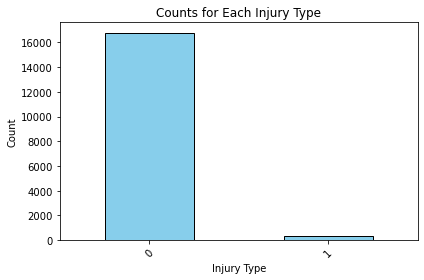

In [32]:
import matplotlib.pyplot as plt

# Calculate counts for each unique value in 'injury_type'
counts = merged_df['injury_type'].value_counts()

# Plot
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Counts for Each Injury Type')
plt.xlabel('Injury Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
merged_df.dtypes

name                 object
club                 object
club_value          float64
birth                object
weight                int64
height               object
country              object
role                 object
foot                 object
season               object
injury_type           int64
days_injured         object
club_country         object
age                   int64
Name                 object
IntCaps               int64
Height                int64
Weight                int64
FirstTouch            int64
Marking               int64
Passing               int64
Tackling              int64
Technique             int64
Aggression            int64
Anticipation          int64
Bravery               int64
Composure             int64
Concentration         int64
Decisions             int64
Determination         int64
Positioning           int64
Teamwork              int64
Workrate              int64
Acceleration          int64
Agility               int64
Balance             

In [34]:
unique_foot_values = merged_df['foot'].unique()
print(unique_foot_values)


['left' 'right' 'both']


In [35]:
merged_df

,name,club,club_value,birth,weight,height,country,role,foot,season,...,InjuryProness,Versatility,Adaptability,Ambition,Loyalty,Pressure,Professional,Sportsmanship,Temperament,Controversy
0,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017-01-01,...,10,13,18,14,12,16,16,9,13,4
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,...,10,10,20,11,10,11,13,8,17,1
2,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,...,4,13,12,13,17,8,17,13,13,7
3,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,...,10,10,20,11,10,11,13,8,17,1
4,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,...,4,13,12,13,17,8,17,13,13,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17100,Ezequiel Ávila,SD Huesca,4680.0,1994-02-06,81,"1,72",Argentina,Forward,left,2019-01-01,...,11,8,9,11,12,12,2,8,17,4
17101,Ezequiel Ávila,SD Huesca,4680.0,1994-02-06,81,"1,72",Argentina,Forward,left,2019-01-01,...,3,10,18,12,10,11,13,6,12,1
17102,Ezequiel Ávila,SD Huesca,4680.0,1994-02-06,81,"1,72",Argentina,Forward,left,2019-01-01,...,11,8,9,11,12,12,2,8,17,4
17103,Ezequiel Ávila,SD Huesca,4680.0,1994-02-06,81,"1,72",Argentina,Forward,left,2019-01-01,...,3,10,18,12,10,11,13,6,12,1


In [36]:
# 1. Drop columns
merged_df = merged_df.drop(columns=['season', 'IntCaps','Technique', 'days_injured', 'Versatility', 'Adaptability', 'Ambition', 
                   'Pressure', 'Professional', 'Sportsmanship', 'Temperament','Consistency', 'country',
                   'Dirtiness', 'club_country', 'ImportantMatches','Composure','Positioning', 'weight','Controversy','Name','Teamwork','FirstTouch', 'Marking', 'Passing', 'Tackling','Decisions', 'Determination','Loyalty', 'Workrate','name', 'club', 'birth','height', 'country'])

# 2. Retain only the year in 'season' column
#merged_df['season'] = merged_df['season'].str[:4]


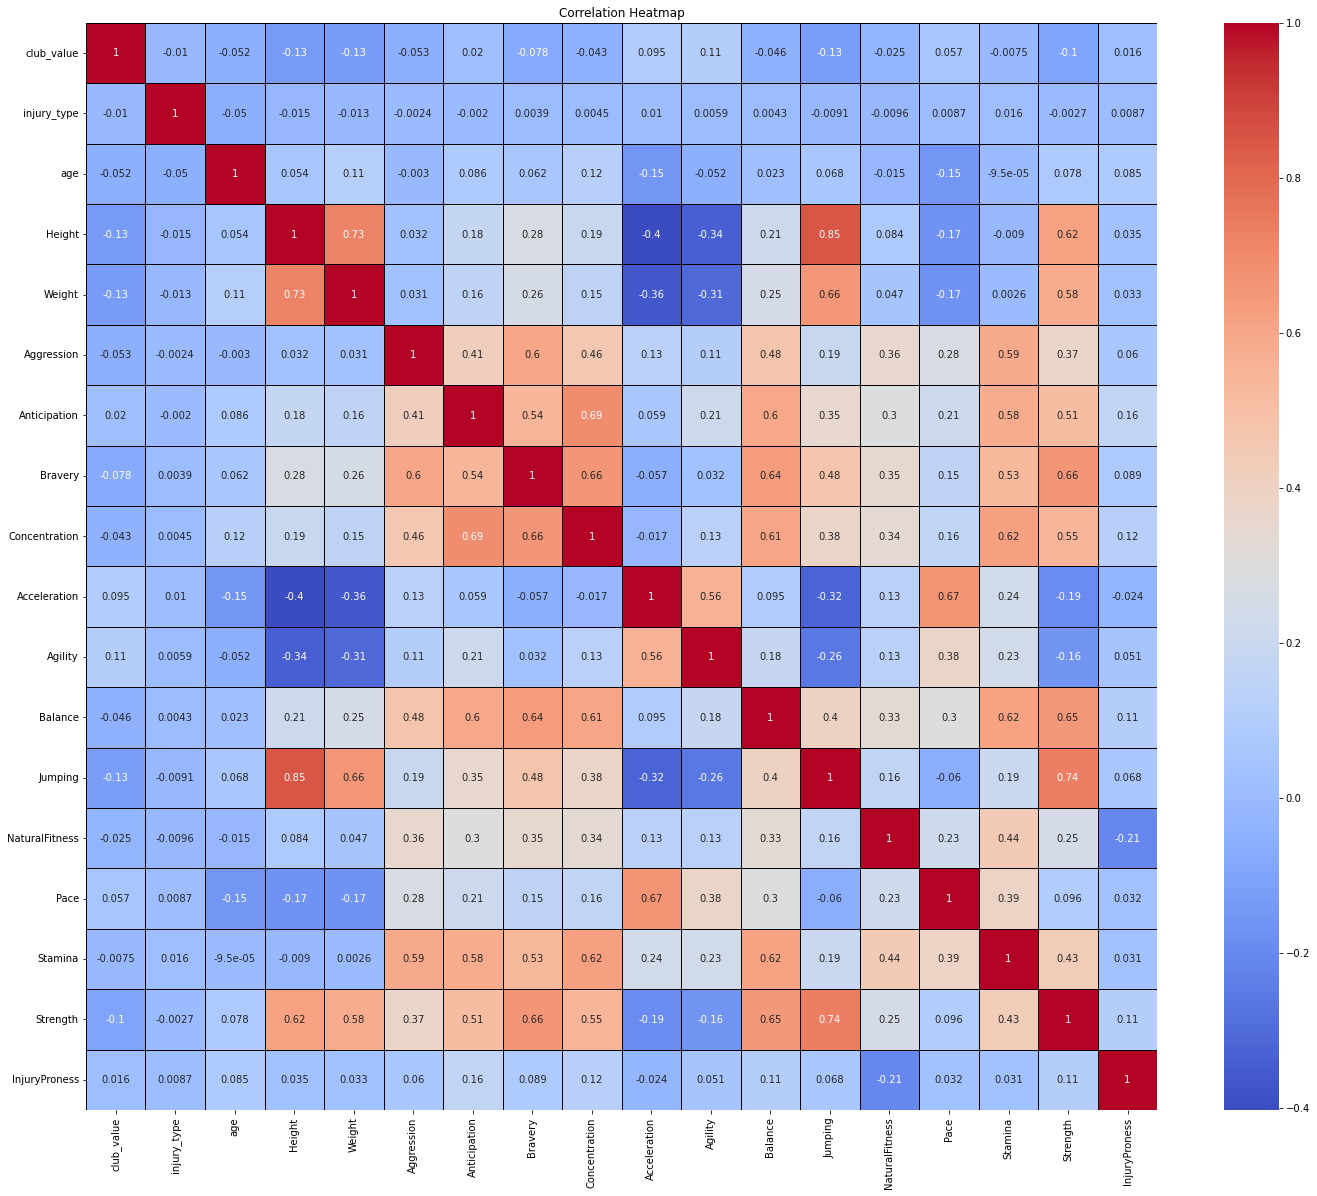

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = merged_df.corr()

# Create a heatmap
plt.figure(figsize=(24,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()

In [38]:
#he original columns 'role', 'foot', 'club_country' will be removed, and new dummy columns will be added in their place. 

# Encode categorical columns
merged_df = pd.get_dummies(merged_df, columns=['role', 'foot',])


In [39]:
#Convert heigh to string , replace comma with empty space(no space), esentially converting to cm 
#remove '\xa0' and convert to float (as height is technically continuos)
#merged_df['height'] = merged_df['height'].astype(str).str.replace(',', '').str.rstrip('\xa0').astype(float)


In [40]:
# Select the columns to be standardized
columns_to_scale = ['club_value' ,'Height', 'Weight', 
                    'Aggression', 'Anticipation', 'Bravery',
                    'Concentration', 
                     'Acceleration',
                   'Agility', 'Balance', 'Jumping', 'NaturalFitness',
                   'Pace', 'Stamina', 'Strength', 
                   'InjuryProness']

In [41]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

#from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
#scaler = MinMaxScaler()
# Apply the scaling
#merged_df[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])

In [42]:
# Convert each column in the list to a float data type
#for col in columns_to_scale:
    #merged_df[col] = merged_df[col].astype(float)

In [43]:
#merged_df[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])

In [44]:
merged_df.shape

(17105, 25)

In [45]:
merged_df

,club_value,injury_type,age,Height,Weight,Aggression,Anticipation,Bravery,Concentration,Acceleration,...,Stamina,Strength,InjuryProness,role_Defender,role_Forward,role_Goalkeeper,role_Midfielder,foot_both,foot_left,foot_right
0,114000.0,0,24,186,83,11,14,16,14,13,...,13,13,10,0,0,1,0,0,1,0
1,114000.0,0,36,171,70,10,5,11,8,14,...,8,8,10,0,0,1,0,0,0,1
2,114000.0,0,36,184,80,12,13,13,15,12,...,13,14,4,0,0,1,0,0,0,1
3,114000.0,0,34,171,70,10,5,11,8,14,...,8,8,10,0,0,1,0,0,0,1
4,114000.0,0,34,184,80,12,13,13,15,12,...,13,14,4,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17100,4680.0,0,25,167,81,10,12,8,10,14,...,14,7,11,0,1,0,0,0,1,0
17101,4680.0,0,25,182,68,10,6,8,8,14,...,8,7,3,0,1,0,0,0,1,0
17102,4680.0,0,25,167,81,10,12,8,10,14,...,14,7,11,0,1,0,0,0,1,0
17103,4680.0,0,25,182,68,10,6,8,8,14,...,8,7,3,0,1,0,0,0,1,0


In [46]:
print(merged_df.columns)


Index(['club_value', 'injury_type', 'age', 'Height', 'Weight', 'Aggression',
       'Anticipation', 'Bravery', 'Concentration', 'Acceleration', 'Agility',
       'Balance', 'Jumping', 'NaturalFitness', 'Pace', 'Stamina', 'Strength',
       'InjuryProness', 'role_Defender', 'role_Forward', 'role_Goalkeeper',
       'role_Midfielder', 'foot_both', 'foot_left', 'foot_right'],
      dtype='object')


In [47]:
merged_df['BMI'] = merged_df['Weight'] / (merged_df['Height'] / 100)**2


In [48]:
# Save DataFrame to CSV
merged_df.to_csv('MERGED_DF.csv', index=False) 


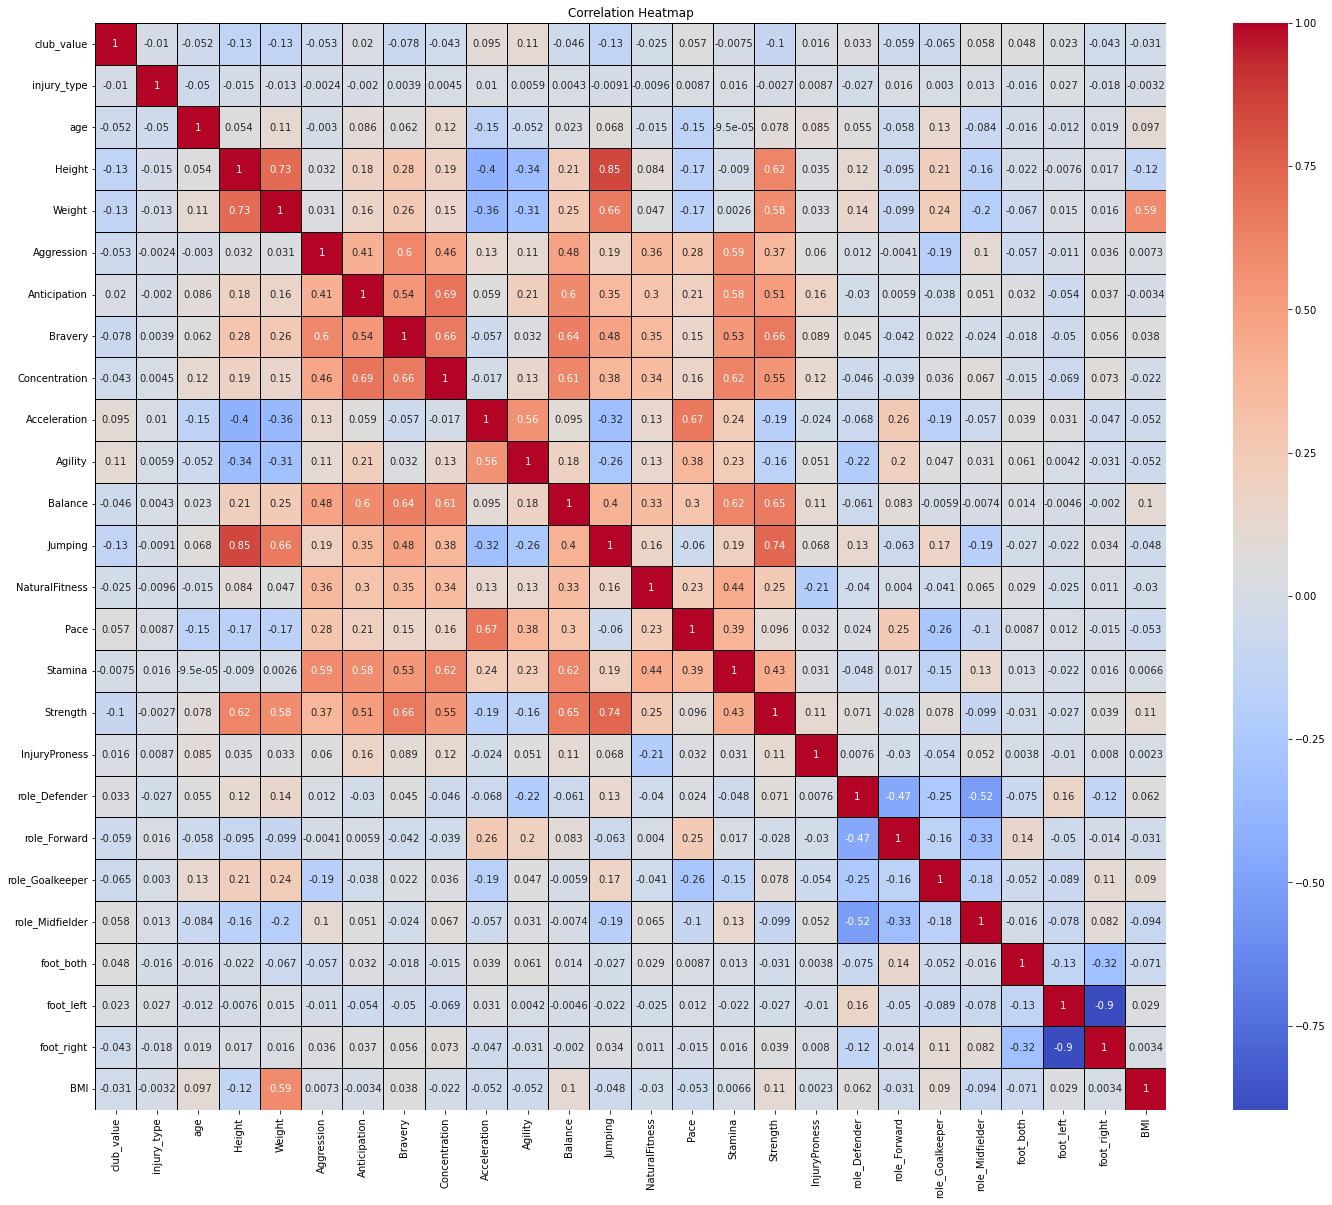

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = merged_df.corr()

# Create a heatmap
plt.figure(figsize=(24,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()


# Adding Expert insight

In [50]:
# Select the columns to be standardized
columns_to_scale = [,
                    'Concentration', 
                     ']

SyntaxError: invalid syntax (2666019295.py, line 2)

In [51]:
# 1. Drop columns
merged_df = merged_df.drop(columns=['Height','Weight', 'Aggression', 'Anticipation',
                                    'Bravery', 'Acceleration',
                   'Agility', 'Balance', 'Jumping', 'NaturalFitness',
                   'Pace', 'Stamina', 'Strength', 
                   'InjuryProness'])


In [52]:
# Save DataFrame to CSV
merged_df.to_csv('MERGED_DF_V2.csv', index=False)

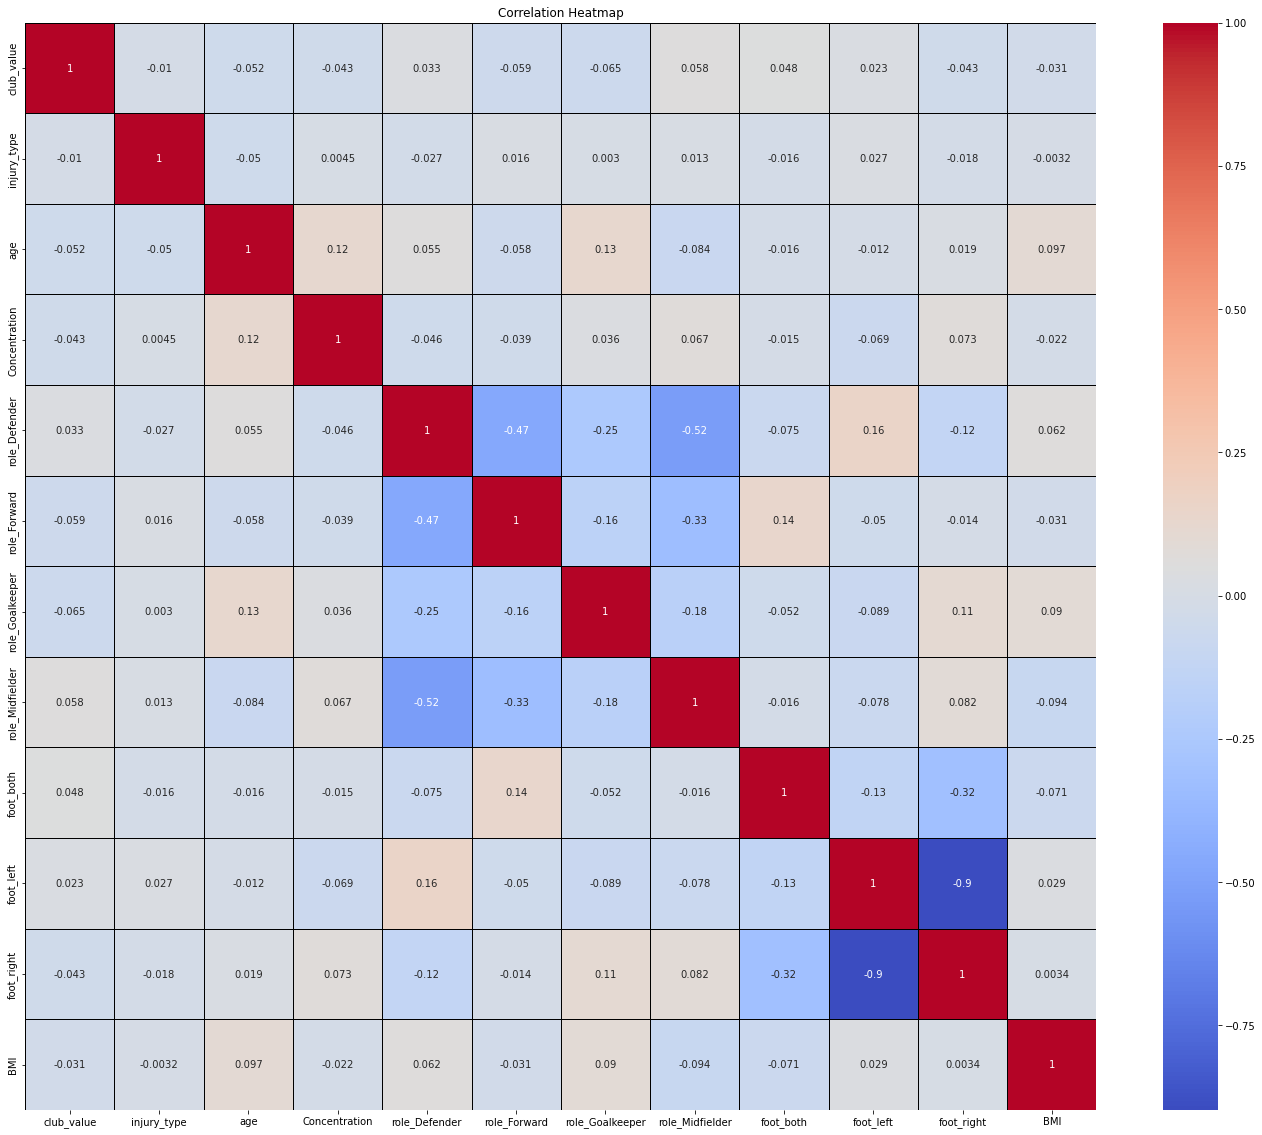

In [53]:
# Calculate the correlation matrix
corr = merged_df.corr()

# Create a heatmap
plt.figure(figsize=(24,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()